In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score
import shap
import warnings
warnings.filterwarnings("ignore")

# 1. load the data and process it
def load_data(file_path, cat_cols = ['gender', 'ethnicity', 'Professional Title', 'major', 'position', 'degree']):
    import openpyxl
    from openpyxl.utils import range_boundaries
    from sklearn.preprocessing import OneHotEncoder
    import pandas as pd

    # 存储指标映射关系
    primary_metrics = {}  # 一级指标
    secondary_metrics = {}  # 二级指标

    # 读取Excel文件
    wb = openpyxl.load_workbook(file_path, data_only=True)
    sheets = wb.sheetnames

    all_data = []

    for sheet in sheets:
        ws = wb[sheet]

        # 获取合并单元格信息
        merged_cells = {}
        for merged_range in ws.merged_cells.ranges:
            min_col, min_row, max_col, max_row = range_boundaries(str(merged_range))
            merged_cells[(min_row, min_col)] = (max_row, max_col)

        # 提取一级指标及其列范围
        primary_positions = []
        for col in range(1, ws.max_column + 1):
            cell = ws.cell(row=1, column=col).value
            if cell is not None:
                key = (1, col)
                if key in merged_cells:
                    end_row, end_col = merged_cells[key]
                    primary_positions.append((cell, col, end_col))
                else:
                    primary_positions.append((cell, col, col))

        # 提取二级指标
        secondary_dict = {}
        for name, start_col, end_col in primary_positions:
            metrics = []
            for col in range(start_col, end_col + 1):
                cell = ws.cell(row=2, column=col).value
                if cell is not None:
                    metrics.append(cell)
            secondary_dict[name] = metrics

        # 存储指标映射关系
        primary_metrics[sheet] = list(secondary_dict.keys())
        secondary_metrics[sheet] = secondary_dict

        # 提取数据
        data_rows = []
        for row in range(3, ws.max_row + 1):
            row_data = {}
            col_idx = 0
            for primary, metrics in secondary_dict.items():
                for metric in metrics:
                    cell = ws.cell(row=row, column=col_idx + 1).value
                    row_data[metric] = cell
                    col_idx += 1
            # 添加最后一列"年度考核"作为目标变量
            cell = ws.cell(row=row, column=col_idx + 1).value
            row_data['score'] = cell
            data_rows.append(row_data)

        # 将数据转换为DataFrame
        df = pd.DataFrame(data_rows)
        all_data.append(df)

    # 合并所有sheet数据
    full_data = pd.concat(all_data, ignore_index=True)

    # 处理缺失值
    full_data = full_data.dropna()

    # 类别型特征处理
    if cat_cols is not None:
        existing_cat_cols = [col for col in cat_cols if col in full_data.columns]
        for col in existing_cat_cols:
            full_data[col] = full_data[col].astype(str)
        full_data_encoded = pd.get_dummies(full_data, columns=cat_cols)
    else:
        full_data_encoded = full_data


    return full_data_encoded, secondary_metrics



In [2]:
def load_data_lableEnc(file_path):
    import openpyxl
    from openpyxl.utils import range_boundaries
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd

    # 存储指标映射关系
    primary_metrics = {}  # 一级指标
    secondary_metrics = {}  # 二级指标

    # 读取Excel文件
    wb = openpyxl.load_workbook(file_path, data_only=True)
    sheets = wb.sheetnames

    all_data = []

    for sheet in sheets:
        ws = wb[sheet]

        # 获取合并单元格信息
        merged_cells = {}
        for merged_range in ws.merged_cells.ranges:
            min_col, min_row, max_col, max_row = range_boundaries(str(merged_range))
            merged_cells[(min_row, min_col)] = (max_row, max_col)

        # 提取一级指标及其列范围
        primary_positions = []
        for col in range(1, ws.max_column + 1):
            cell = ws.cell(row=1, column=col).value
            if cell is not None:
                key = (1, col)
                if key in merged_cells:
                    end_row, end_col = merged_cells[key]
                    primary_positions.append((cell, col, end_col))
                else:
                    primary_positions.append((cell, col, col))

        # 提取二级指标
        secondary_dict = {}
        for name, start_col, end_col in primary_positions:
            metrics = []
            for col in range(start_col, end_col + 1):
                cell = ws.cell(row=2, column=col).value
                if cell is not None:
                    metrics.append(cell)
            secondary_dict[name] = metrics

        # 存储指标映射关系
        primary_metrics[sheet] = list(secondary_dict.keys())
        secondary_metrics[sheet] = secondary_dict

        # 提取数据
        data_rows = []
        for row in range(3, ws.max_row + 1):
            row_data = {}
            col_idx = 0
            for primary, metrics in secondary_dict.items():
                for metric in metrics:
                    cell = ws.cell(row=row, column=col_idx + 1).value
                    row_data[metric] = cell
                    col_idx += 1
            # 添加最后一列"年度考核"作为目标变量
            cell = ws.cell(row=row, column=col_idx + 1).value
            row_data['score'] = cell
            data_rows.append(row_data)

        # 将数据转换为DataFrame
        df = pd.DataFrame(data_rows)
        all_data.append(df)

    # 合并所有sheet数据
    full_data = pd.concat(all_data, ignore_index=True)

    # 处理缺失值
    full_data = full_data.dropna()

    # 类别型特征处理
    cat_cols = ['性别', '民族', '职称', '专业', '职务', '学历']
    existing_cat_cols = [col for col in cat_cols if col in full_data.columns]

    # 使用LabelEncoder进行编码
    for col in existing_cat_cols:
        le = LabelEncoder()
        full_data[col] = le.fit_transform(full_data[col].astype(str))

    # 返回编码后的数据和指标映射
    return full_data, secondary_metrics

### create teacher score profile

In [3]:
import importlib
# 2. 教师画像生成
def generate_teacher_profile(model, X, teacher_idx=0):
    # 获取单个教师数据
    X_sample = X.iloc[[teacher_idx]]
    
    # 一级指标得分
    primary_scores = {}
    for col in X_sample.columns:
        primary_scores[col] = X_sample[col].values[0]
    
    # 总体评分
    overall_score = model.predict(X_sample)[0]
    
    return primary_scores, overall_score

### model initialization

In [4]:
def initialize_model(module_name, class_name, params):
    """
    通过字符串初始化模型，并传递参数。

    参数:
    - module_name: 模块名
    - class_name: 类名
    - params: 模型的初始化参数（字典形式）

    返回:
    - 初始化后的模型对象
    """
    # 动态导入模块
    module = importlib.import_module(module_name)
    
    # 获取类
    ModelClass = getattr(module, class_name)
    
    # 实例化对象
    model = ModelClass(**params)
    
    return model

### train model functions

In [5]:
def train_models_n(X, y, feature_groups, 
                 module_name = 'sklearn.ensemble',
                 sec_model_name = 'RandomForestRegressor',
                 sec_model_params = {'n_estimators': 100, 'random_state': 42},
                 overall_model = RandomForestRegressor(n_estimators=100, random_state=42)):
    # 特征分组
    group_models = {}
    # training scores for secondary indicators
    group_scores = {}
    # testing scores for secondary indicators
    group_test_scores = {}
    group_features = {}  # 用于保存特征名称
    group_train_data = {}  # 用于保存训练数据
    group_test_data = {}  # 用于保存测试数据
    group_sec_scaler = {}
    # 训练一级指标模型
    for metric, features in feature_groups.items():
        # 筛选有效特征
        valid_features = [f for f in features if f in X.columns]
        if len(valid_features) == 0:
            continue
            
        # 数据分割
        X_train, X_test, y_train, y_test = train_test_split(
            X[valid_features], y, test_size=0.2, random_state=42)
        
        # 标准化
        # scaler = StandardScaler()
        scaler = MinMaxScaler()  # 使用MinMaxScaler进行归一化
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
         
        # 模型训练
        # sec_model = RandomForestRegressor(n_estimators=100, random_state=42)
        sec_model = initialize_model(module_name, sec_model_name, sec_model_params)
        sec_model.fit(X_train_scaled, y_train)
        
        # 存储模型和得分
        group_models[metric] = sec_model
        group_test_scores[metric] = sec_model.score(X_test_scaled, y_test)
        group_scores[metric] = sec_model.score(X_train_scaled, y_train)
        group_features[metric] = valid_features  # 手动保存特征名称
        group_train_data[metric] = X_train_scaled
        group_test_data[metric] = X_test_scaled
        group_sec_scaler[metric] = scaler
    # 训练总体评分模型
    X_group = pd.DataFrame()
    X_test_group = pd.DataFrame()
    for metric, model in group_models.items():
        # feature_names = group_features[metric] 
        X_group[metric] = model.predict(group_train_data[metric])
        X_test_group[metric] = model.predict(group_test_data[metric])
    
    # 标准化
    # scaler = StandardScaler()
    fisrt_scaler = MinMaxScaler()  # 使用MinMaxScaler进行归一化
    X_train_scaled = fisrt_scaler.fit_transform(X_group)
    X_test_scaled = fisrt_scaler.transform(X_test_group)
    # 总体评分模型
    # overall_model = RandomForestRegressor(n_estimators=100, random_state=42)
    overall_model.fit(X_train_scaled, y_train)
    # 计算总体评分
    # overall_train_score = overall_model.score(X_train_scaled, y_train)
    overall_test_score = overall_model.score(X_test_scaled, y_test)
    
    return group_models, overall_model, group_scores, group_features, \
    overall_test_score, group_sec_scaler, fisrt_scaler

In [6]:
def train_models(X, y, feature_groups, 
                 module_name = 'sklearn.ensemble',
                 sec_model_name = 'RandomForestRegressor',
                 sec_model_params = {'n_estimators': 100, 'random_state': 42},
                 overall_model = RandomForestRegressor(n_estimators=100, random_state=42)):
    # 特征分组
    group_models = {}
    # training scores for secondary indicators
    group_scores = {}
    # testing scores for secondary indicators
    group_test_scores = {}
    group_features = {}  # 用于保存特征名称
    # 训练一级指标模型
    for metric, features in feature_groups.items():
        # 筛选有效特征
        valid_features = [f for f in features if f in X.columns]
        if len(valid_features) == 0:
            continue
            
        # 数据分割
        X_train, X_test, y_train, y_test = train_test_split(
            X[valid_features], y, test_size=0.2, random_state=42)
        
        # 标准化
        # scaler = StandardScaler()
        scaler = MinMaxScaler()  # 使用MinMaxScaler进行归一化
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
         
        # 模型训练
        # sec_model = RandomForestRegressor(n_estimators=100, random_state=42)
        sec_model = initialize_model(module_name, sec_model_name, sec_model_params)
        sec_model.fit(X_train_scaled, y_train)
        
        # 存储模型和得分
        group_models[metric] = sec_model
        group_test_scores[metric] = sec_model.score(X_test_scaled, y_test)
        group_scores[metric] = sec_model.score(X_train_scaled, y_train)
        group_features[metric] = valid_features  # 手动保存特征名称
    
    # 训练总体评分模型
    X_group = pd.DataFrame()
    for metric, model in group_models.items():
        feature_names = group_features[metric] 
        X_group[metric] = model.predict(X[feature_names])
    
    # 标准化
    # scaler = StandardScaler()
    # scaler = MinMaxScaler()  # 使用MinMaxScaler进行归一化
    # X_train_scaled = scaler.fit_transform(X_group)
    
    # 总体评分模型
    # overall_model = RandomForestRegressor(n_estimators=100, random_state=42)
    overall_model.fit(X_group, y)

    # 计算总体评分
    for metric, model in group_models.items():
        feature_names = group_features[metric] 
        X_group[metric] = model.predict(X_test_scaled[feature_names])
    overall_scores = overall_model.score(X_test_scaled, y_test)  
    # overall_r2 = r2_score(y, overall_scores)
    
    return group_models, overall_model, group_scores, group_features,group_test_scores,overall_scores


### SHAP分析

#### first-level indicator analysis

In [7]:
# 4. SHAP分析
def perform_shap_analysis(model, X, feature_names):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    
    # 绘制SHAP摘要图
    shap.summary_plot(shap_values, X, feature_names=feature_names)
    plt.title("Teacher competence index SHAP Summary Plot")
    
    return explainer, shap_values

#### second-level indication analysis

In [8]:
def analyze_primary_metric_shap(model, X, features, primary_metric_name, 
                              feature_names=None, plot_type='summary', 
                              max_display=10, plot_title=None):
    """
    对指定一级指标进行SHAP分析
    
    参数:
        model: 训练好的一级指标模型
        X: 特征数据（原始数据）
        features: 该一级指标使用的特征列名列表
        primary_metric_name: 一级指标名称（用于图表标题）
        feature_names: 特征名称映射表（可选）
        plot_type: 可视化类型 ['summary', 'bar', 'force']
        max_display: 显示的最大特征数量
        plot_title: 自定义图表标题（可选）
    
    返回:
        shap_values: SHAP值对象
    """
    # 1. 确保输入数据正确
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=features)
    
    # 2. 创建SHAP解释器
    explainer = shap.Explainer(model, X[features])
    shap_values = explainer(X[features])
    
    # 3. 特征名称处理
    if feature_names is None:
        feature_names = features
    
    # 4. 可视化分析
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    if plot_title is None:
        plot_title = f"{primary_metric_name} indicator SHAP analysis"
    
    # 5. 不同可视化类型
    if plot_type == 'summary':
        shap.summary_plot(
            shap_values.values, 
            X[features], 
            feature_names=feature_names,
            max_display=max_display,
            show=False
        )
        plt.title(plot_title + " (Summary Plot)")
        
    elif plot_type == 'bar':
        shap.plots.bar(
            shap_values, 
            max_display=max_display,
            show=False
        )
        plt.title(plot_title + " (Bar Plot)")
    
    elif plot_type == 'force':
        shap.force_plot(
            explainer.expected_value, 
            shap_values[0].values, 
            X.iloc[0][features],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(plot_title + " (Force Plot)")
    
    # 6. 显示图表
    plt.tight_layout()
    plt.show()
    
    return shap_values

### visualization

In [9]:
def visualize_profiles(scores, avg_scores, max_scores, title):
    """
    绘制雷达图，展示教师在各项指标上的得分，并与平均分和最高分对比
    
    参数:
        scores (dict): 教师个人得分，如 {'自然状况': 8.5, '科研创新': 7.2, ...}
        avg_scores (dict): 每项指标的平均得分，如 {'自然状况': 7.3, '科研创新': 6.8, ...}
        max_scores (dict): 每项指标的最高得分，如 {'自然状况': 9.2, '科研创新': 9.0, ...}
        title (str): 雷达图标题
    """
    # 获取指标名称和得分
    metrics = list(scores.keys())
    scores_values = list(scores.values())
    avg_values = [avg_scores[m] for m in metrics]
    max_values = [max_scores[m] for m in metrics]

    # 闭合雷达图数据
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    scores_values += scores_values[:1]
    avg_values += avg_values[:1]
    max_values += max_values[:1]
    angles += angles[:1]

    # 设置中文显示
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    # 创建雷达图
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

    # 绘制三条折线
    ax.fill(angles, scores_values, color='red', alpha=0.25)
    ax.plot(angles, scores_values, color='red', linewidth=2, label='teacher score')
    ax.plot(angles, avg_values, color='blue', linestyle='--', linewidth=2, label='mean score')
    ax.plot(angles, max_values, color='green', linestyle='-.', linewidth=2, label='max score')

    # 设置标签
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_yticklabels([])  # 隐藏y轴标签
    ax.set_title(title, size=16, color='black', pad=30)

    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    # plt.grid(True, linestyle='-', alpha=0.5)
    plt.show()


### main function

In [28]:
# 1. 数据加载与预处理
file_path = 'teacher_info_2025_name-7-3-english.xlsx'
data_encoded, secondary_metrics = load_data(file_path)

# 2. 准备特征和标签
X = data_encoded.drop(['score'], axis=1)
y = data_encoded['score'].astype(int)

# 3. 特征分组
feature_groups = {}
for sheet in secondary_metrics.values():
    for primary, metrics in sheet.items():
        group_features = []
        for feat in metrics:
            # 处理One-hot编码后的特征
            group_features.extend([col for col in X.columns if col.startswith(feat+'_') or col == feat])
        feature_groups[primary] = group_features

# 4. 模型训练
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler = \
            train_models_n(X, y, feature_groups,
                         module_name='sklearn.ensemble',
                 sec_model_name='RandomForestRegressor',
                 sec_model_params={'n_estimators': 100, 'random_state': 42},
                 overall_model=RandomForestRegressor(n_estimators=100, random_state=42))
    
# 5. 教师画像分析, X_group 中存储了各一级指标的预测值
X_group = pd.DataFrame()
for metric, model in group_models.items():
    # X_group[metric] = model.predict(X[group_models[metric].feature_names_in_])
    # 使用已保存的特征名称
    second_x = second_scaler[metric].transform(X[zb_features[metric]])
    X_group[metric] = model.predict(second_x)




### radar plot

In [31]:
# primary_scores
print(overall_score, primary_scores)

1.0 {'Basic Background': 0.96, 'Scientific Innovation': 0.872, 'Social Service': 0.16886249304074127, 'Competition Guidance': 0.68, 'Teaching Cultivation ': 0.65}


总体评分: 1.00

各指标得分:
Basic Background: 0.96
Scientific Innovation: 0.87
Social Service: 0.17
Competition Guidance: 0.68
Teaching Cultivation : 0.65


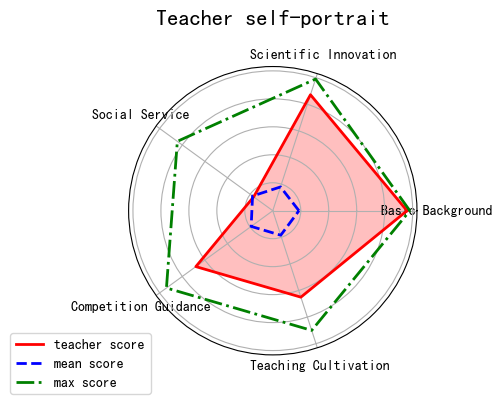

In [29]:
# 选择示例教师
teacher_idx = 10
primary_scores, overall_score = generate_teacher_profile(overall_model, \
                                                            X_group, 
                                                            teacher_idx)
# 计算平均得分
avg_scores = {}
max_scores = {}

# 遍历每个一级指标及其对应的模型
for metric, model in group_models.items():
    # 获取该模型所使用的特征列
    features = zb_features[metric]
    
    # 使用模型进行预测
    second_x = second_scaler[metric].transform(X[features])
    predictions = model.predict(second_x)
    
    # 计算平均得分和最高得分
    avg_scores[metric] = np.mean(predictions)
    max_scores[metric] = np.max(predictions)
# 6. 可视化
print(f"总体评分: {overall_score:.2f}")
print("\n各指标得分:")
for metric, score in primary_scores.items():
    print(f"{metric}: {score:.2f}")

visualize_profiles(primary_scores, avg_scores, max_scores,"Teacher self-portrait")

### shap 分析

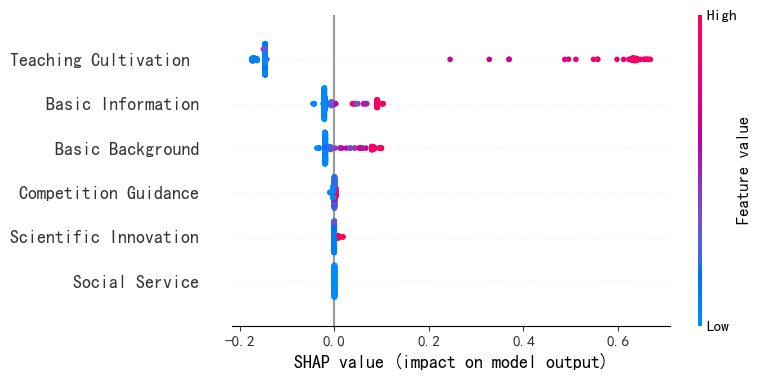

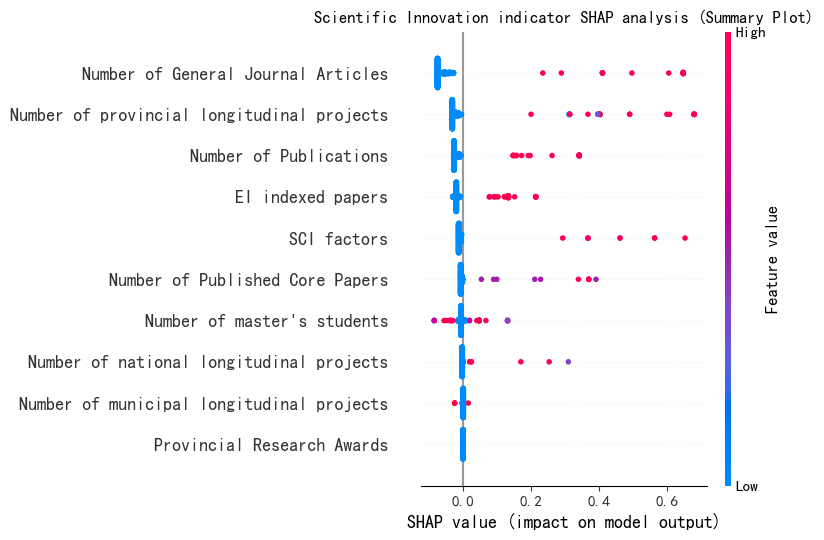


各指标R²分数:
Basic Background R²: 0.82
Scientific Innovation R²: 0.47
Social Service R²: 0.07
Competition Guidance R²: 0.46
Teaching Cultivation  R²: 0.83
Basic Information R²: 0.82


In [20]:
# 7. SHAP分析
explainer, shap_values = perform_shap_analysis(overall_model, X_group, X_group.columns.tolist())

# 假设我们有以下变量：
# group_models - 保存所有一级指标模型的字典
# X - 原始特征数据
# zb_features - 保存每个一级指标对应的特征列名

# 示例：分析"自然状况"指标
zb_name = 'Scientific Innovation'
shap_values = analyze_primary_metric_shap(
    model=group_models[zb_name],
    X=X,
    features=zb_features[zb_name],
    primary_metric_name=zb_name,
    plot_type='summary',
    max_display=10
)
# 打印模型性能
print("\n各指标R²分数:")
for metric, score in group_scores.items():
    print(f"{metric} R²: {score:.2f}")

In [27]:
group_models

{'Basic Background': RandomForestRegressor(random_state=42),
 'Scientific Innovation': RandomForestRegressor(random_state=42),
 'Social Service': RandomForestRegressor(random_state=42),
 'Competition Guidance': RandomForestRegressor(random_state=42),
 'Teaching Cultivation ': RandomForestRegressor(random_state=42),
 'Basic Information': RandomForestRegressor(random_state=42)}

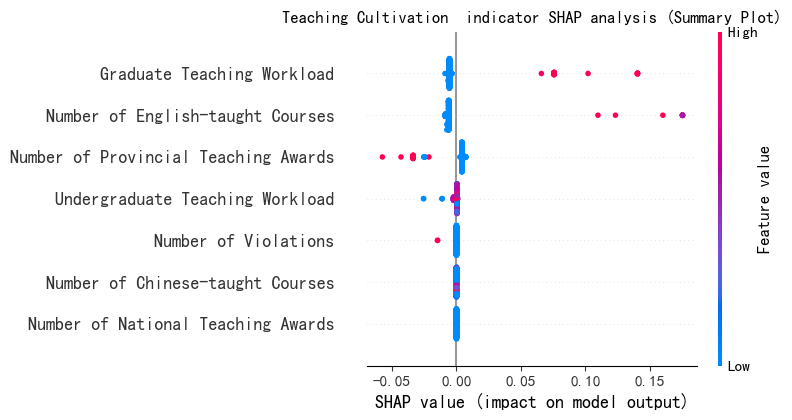

In [26]:
zb_name = 'Teaching Cultivation '
shap_values = analyze_primary_metric_shap(
    model=group_models[zb_name],
    X=X,
    features=zb_features[zb_name],
    primary_metric_name=zb_name,
    plot_type='summary',
    max_display=10
)

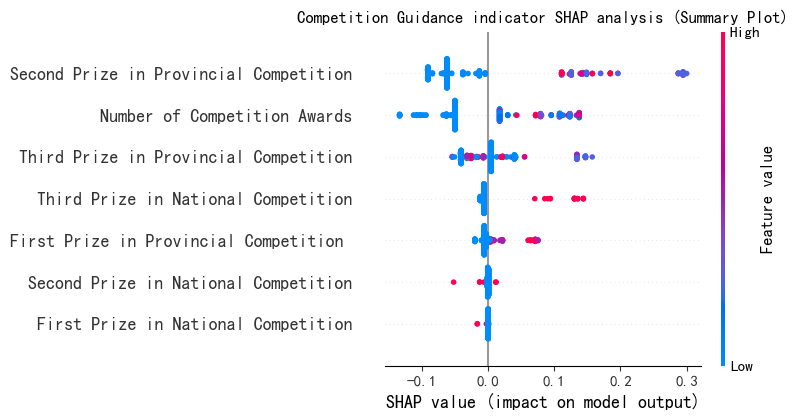

In [ ]:
zb_name = 'Competition Guidance'
shap_values = analyze_primary_metric_shap(
    model=group_models[zb_name],
    X=X,
    features=zb_features[zb_name],
    primary_metric_name=zb_name,
    plot_type='summary',
    max_display=10
)

## employ the classifier for accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# module
from xgboost import XGBClassifier
group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'xgboost',
                                              sec_model_name='XGBClassifier',
                            sec_model_params={'learning_rate':0.1, 'n_estimators':100,'max_depth': 4, 'random_state': 55},
                         overall_model=XGBClassifier(learning_rate=0.1,         # 学习率
                       n_estimators=100,         # 树的数量
                       max_depth=3,              # 树的最大深度
                       eval_metric='logloss', random_state=55)
)
print('xgboost test accuracy:', group_test_scores)

group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.linear_model',
                                              sec_model_name='LogisticRegression',
                            sec_model_params={'C': 100, 'random_state': 55},
                         overall_model=LogisticRegression(C=1.0, random_state=55)
)
print('logistic test accuracy:', group_test_scores)

group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.tree',
                                              sec_model_name='DecisionTreeClassifier',
                            sec_model_params={'max_depth': 4, 'random_state': 55},
                         overall_model=DecisionTreeClassifier(max_depth=4, random_state=55)
)
print('decision tree accuracy:', group_test_scores)

group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.ensemble',
                                              sec_model_name='RandomForestClassifier',
                            sec_model_params={'n_estimators': 100, 'random_state': 55},
                         overall_model=RandomForestClassifier(n_estimators=100, random_state=55)
)
print('random forest test accuracy:', group_test_scores)


group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.svm',
                                              sec_model_name='SVC',
                            sec_model_params={'C': 1, 'random_state': 55, 'kernel': 'rbf'},
                         overall_model=SVC(C=1, kernel='rbf', random_state=55)
)
print('svm test accuracy:', group_test_scores)

group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.ensemble',
                                              sec_model_name='RandomForestClassifier',
                            sec_model_params={'n_estimators': 100, 'random_state': 55},
                         overall_model=LogisticRegression(C=1.0, random_state=55)
)
print('random forest+ logistic test accuracy:', group_test_scores)

group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.linear_model',
                                              sec_model_name='LogisticRegression',
                            sec_model_params={'C': 100, 'random_state': 55},
                         overall_model=RandomForestClassifier(n_estimators=100, random_state=55)
)
print('logistic+random forest test accuracy:', group_test_scores)


group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.linear_model',
                                              sec_model_name='LogisticRegression',
                            sec_model_params={'C': 100, 'random_state': 55},
                         overall_model=SVC(C=2, kernel='rbf',gamma='auto', random_state=55)
)
print('logistic+SVM test accuracy:', group_test_scores)


group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.svm',
                                              sec_model_name='SVC',
                            sec_model_params={'C': 1, 'random_state': 55, 'kernel': 'rbf'},
                         overall_model=LogisticRegression(C=1, random_state=55)
)
print('svm+logistic test accuracy:', group_test_scores)

group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.tree',
                                              sec_model_name='DecisionTreeClassifier',
                            sec_model_params={'max_depth': 4, 'random_state': 55},
                         overall_model=LogisticRegression(C=1, random_state=55)
)
print('tree+logistic test accuracy:', group_test_scores)

group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'sklearn.linear_model',
                                              sec_model_name='LogisticRegression',
                            sec_model_params={'C':0.1, 'random_state': 55},
                         overall_model=XGBClassifier(learning_rate=0.1,         # 学习率
                       n_estimators=100,         # 树的数量
                       max_depth=3,              # 树的最大深度
                       eval_metric='logloss', random_state=55)
)
print('logistic+xgboost test accuracy:', group_test_scores)


group_models, 
overall_model, 
group_scores, 
group_models, overall_model, group_scores, \
        zb_features,group_test_scores,second_scaler, first_scaler= train_models_n(X, y, feature_groups,
                                              module_name = 'xgboost',
                                              sec_model_name='XGBClassifier',
                            sec_model_params={'learning_rate':0.1, 'n_estimators':100,'max_depth': 5, 'random_state': 55},
                         overall_model=LogisticRegression(C=1.2, random_state=55)
)
print('xgboost+logistic test accuracy:', group_test_scores)

xgboost test accuracy: 0.8412698412698413
logistic test accuracy: 0.7936507936507936
decision tree accuracy: 0.8412698412698413
random forest test accuracy: 0.8888888888888888
svm test accuracy: 0.746031746031746
random forest+ logistic test accuracy: 0.9047619047619048
logistic+random forest test accuracy: 0.7619047619047619
logistic+SVM test accuracy: 0.7619047619047619
svm+logistic test accuracy: 0.7777777777777778
tree+logistic test accuracy: 0.8888888888888888
logistic+xgboost test accuracy: 0.873015873015873
xgboost+logistic test accuracy: 0.8571428571428571
